# Abordagem 1 - Extrator de paleta de cores - Algoritmo de clusterização

In [1]:
import os
from os.path import isfile, join
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from scipy.cluster.vq import whiten
from matplotlib import pyplot as plt
from matplotlib import image as img
import multiprocessing as mp
import paleta_multiprocessing
from colormap import rgb2hex
import ast
import plotly.graph_objects as go



## Encontrar arquivos para extrair paleta

In [66]:
# artistName = 'frida-kahlo'
# folderName = 'rescaled_dataset_artistas\\' + artistName
# folderName = 'dataset_artistas\\frida-kahlo\\1952'
# folderName = 'dataset_artistas\\andy-warhol\\1960'
folderName = 'rescaled_dataset_artistas'

fileList = []
for paths, dirs, files in os.walk(folderName):
    for file in files:
        if file.endswith(".jpg"):
                id = os.path.splitext(file)[0]
                fileList.append((os.path.join(paths, file), id))


# #Pega todos os anos disponiveis
# pathArtista = 'rescaled_dataset_artistas\\' + artistName + '\\'
# anos = os.listdir(pathArtista)

In [67]:
#Load all dataframes
dfList = []
d = 'dataset_artistas'
artistasFiles = [os.path.join(d,o) for o in os.listdir(d) if os.path.isfile(os.path.join(d,o))]

for artista in artistasFiles:
    dfList.append(pd.read_json(artista, orient='records'))

dfAll = pd.concat(dfList, ignore_index=True)
dfAll['contentId'] = dfAll['contentId'].astype(str)

#Add path to dataframe
dfFiles = pd.DataFrame(fileList, columns =['path', 'contentId'])
dfAll = pd.merge(dfAll, dfFiles, on=["contentId"])

#Remover "sketch and study"
dfAll = pd.DataFrame(dfAll[dfAll['genre']!="sketch and study"]) 

## Passo 1:  Extrair paleta de todas as obras

### Utilização do K-means para extrair as cores

In [68]:
# Contar a dominancia de cada cor da paleta
def dominaciaCores(labels):

    counter = Counter(labels)
    dominaceList = sorted([(i, counter[i] / len(labels) * 100.0) for i in counter])
    return [i[1] for i in dominaceList ]

In [70]:
def kmeanCores(dataframeRGB, nClusters):

    df = dataframeRGB
    df['r_whiten'] = whiten(df['r'])
    df['g_whiten'] = whiten(df['g'])
    df['b_whiten'] = whiten(df['b'])

    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(df[['r_whiten', 'g_whiten', 'b_whiten']])

    cluster_centers = kmeans.cluster_centers_

    r_std, g_std, b_std = df[['r', 'g', 'b']].std()
    
    #Calcula cores finais da paleta baseada no centroid do cluster
    colors=[]
    for color in cluster_centers:
        sr, sg, sb = color

        r, g, b = (int(sr*r_std), int(sg*g_std), int(sb*b_std))
        r = 255 if r>255 else r
        g = 255 if g>255 else g
        b = 255 if b>255 else b
        colors.append((r,g,b))

    #Calcula o percentual de dominacia de cada cor
    dominacia = dominaciaCores(kmeans.labels_)

    return (colors, dominacia)


In [71]:
def extratorPaleta(filePath, id):

    #Lê o arquivo de imagem
    image = img.imread(filePath)

    #Constroi dataframe de cores
    df = pd.DataFrame()
    df['r']=pd.Series(image[:,:,0].flatten())
    df['g']=pd.Series(image[:,:,1].flatten())
    df['b']=pd.Series(image[:,:,2].flatten())
    (colors, dominacia) = kmeanCores(df, 10)
    
    ano = os.path.basename(os.path.dirname(filePath))
    return [id, ano, colors, dominacia]

In [72]:
#Extraindo a paleta de cores de todas as obras
artista = 'Kahlo Frida '
# fileListArtista =  dfAll[dfAll['artistName'] == artista]['path'].to_list()
dfArtista = dfAll[dfAll['artistName'] == artista]
fileListArtista =  list(zip(dfArtista.path, dfArtista.contentId))

dadosCores = []
for pathArquivo, id in fileListArtista:
    dadosCores.append(extratorPaleta(pathArquivo, id))

In [ ]:
#Testando multiprocessing em python
if __name__ == '__main__':

    PROCESSES = 4
    pool = mp.Pool(PROCESSES)
    dadosCores = pool.starmap(paleta_multiprocessing.extratorPaleta, fileList)

### Salva em arquivo

In [73]:
# Ajeitar lista para ficar mais fácil de ler csv salvo
listaSalvar = []
for idObra, ano, paleta, dominacia in dadosCores:
    for rgb, percentual in zip(paleta,dominacia):
        listaSalvar.append([idObra, ano, rgb, percentual])

#Salva csv
df = pd.DataFrame(listaSalvar, columns = ['contentId', 'completitionYear', 'paleta_rgb', 'paleta_dominancia'])
df.to_csv(f'paletas\\raw_artistas\\paleta_raw_{artista}.csv', index=False)

## Passo 2: Extrair paleta de conjunto de paletas individuais
- Paleta de todos os anos
- Paleta por ano

In [74]:
#Ler arquivo de paleta
dfPaleta = pd.read_csv(f'paletas\\raw_artistas\\paleta_raw_{artista}.csv')
#Carregar dataframe
dfPaleta.paleta_rgb = dfPaleta.paleta_rgb.apply(lambda x: ast.literal_eval(x))	
dfPaleta[['r', 'g', 'b']] = pd.DataFrame(dfPaleta['paleta_rgb'].tolist(), index=dfPaleta.index)


In [75]:
#Visualizacao da distribuicao dos pontos das paletas
fig = go.Figure(data=go.Scatter3d(
    x=dfPaleta.r.to_list(),
    y=dfPaleta.g.to_list(),
    z=dfPaleta.b.to_list(),
    mode='markers',
    marker=dict(size=3,
                color=dfPaleta.paleta_rgb.to_list())
))

fig.show()

## K-means para extrair paletas

In [76]:
##Ordenada dataframe de paleta baseado em uma paleta base -> Uso do kneighbors
def ordenarPaleta(paletaBase, paletaOrdenar):
    df = paletaOrdenar
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(paletaBase[['r', 'g', 'b']])
    colorOrderClass = neigh.kneighbors(paletaOrdenar[['r', 'g', 'b']],return_distance=False)
    df['ordem'] = colorOrderClass.flatten()
    df.sort_values(by=['ordem'], inplace=True)
    return df.reset_index(drop=True)

### Paleta de todos as anos 

In [77]:
colors, dominancia = kmeanCores(dfPaleta,15)

paletaAnos = pd.DataFrame(colors, columns = ['r', 'g', 'b'])
#Abrir df paleta base
paletaBase = pd.read_csv('paletas\\base\\paleta_cores_120.csv')
paletaAnos = ordenarPaleta(paletaBase,paletaAnos)

# Comentar para evitar quebra o código
# t = paletaAnos[['r','g','b']].to_records(index=False)
# plt.imshow([t.tolist()])
# plt.show()

## 3. Salvar em arquivo

### Paleta por ano

In [100]:
paletaPorAno = []
anos = dfAll[dfAll['artistName'] == artista]['completitionYear'].unique()

for ano in anos:
    dfAno =  pd.DataFrame(dfPaleta.loc[dfPaleta['completitionYear'] == int(ano)])
    colors, dominancia = kmeanCores(dfAno,10)
    paletaPorAno.append(colors)

In [107]:
#Ordenar paleta
dfPorAno = []
for ano, paleta in zip(anos,paletaPorAno):
    paletaOrdenada = ordenarPaleta(paletaBase,pd.DataFrame(paleta, columns = ['r', 'g', 'b']))
    paletaOrdenada['hex'] = paletaOrdenada.apply(lambda row: rgb2hex(row['r'], row['g'], row['b']), axis=1)
    paletaOrdenada['completitionYear'] = ano
    dfPorAno.append(paletaOrdenada)


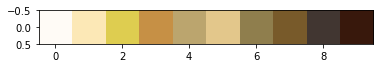

In [390]:
# Comentar para evitar quebra o código
# t = dfPorAno[7][['r','g','b']].to_records(index=False)
# plt.imshow([t.tolist()])
# plt.show()

### Salvar paletas

In [114]:
#Paleta Geral
paletaAnos.to_csv(f'paletas\\final_artistas\\paleta_{artista}.csv', index=False)

#Paleta por ano
todosAnosDf = pd.concat(dfPorAno, ignore_index=True)
todosAnosDf.to_csv(f'paletas\\final_artistas\\paleta_anos_{artista}.csv', index=False)


In [106]:
todosAnosDf

,r,g,b,ordem,hex,completitionYear
0,251,247,227,1,#FBF7E3,1922.0
1,247,236,202,1,#F7ECCA,1922.0
2,225,153,69,89,#E19945,1922.0
3,200,135,66,93,#C88742,1922.0
4,150,113,84,96,#967154,1922.0
...,...,...,...,...,...,...
275,146,115,84,96,#927354,1954.0
276,145,141,156,100,#918D9C,1954.0
277,114,80,60,101,#72503C,1954.0
278,65,46,37,104,#412E25,1954.0


# Passo 3 - Quantificar de acordo com paleta

### 1. Leitura da paleta

In [83]:
paletaCores = pd.read_csv(f'paletas\\final_artistas\\paleta_{artista}.csv')
paletaCores['hex'] = paletaCores.apply( lambda row: rgb2hex(row['r'], row['g'], row['b']), axis=1)

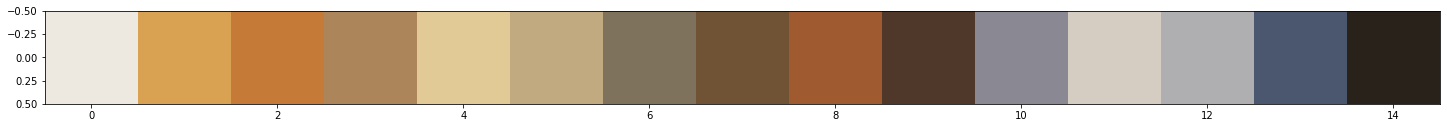

In [84]:
# Mostra imagem da paleta --> comentar antes de usar pode quebrar os código, pois transforma int em numpy int
t = paletaCores[['r','g','b']].to_records(index=False)
plt.figure(figsize = (25,4))
plt.imshow([t.tolist()])
plt.show()


### 2. Classificação de acordo com a paleta -> Uso de k-neighbour

In [85]:
#Calcula a frequencia de cores de um obra
def calculoImagem(path, classificador):
    image = img.imread(path)

    #Constroi dataframe de cores
    df = pd.DataFrame()
    df['r']=pd.Series(image[:,:,0].flatten())
    df['g']=pd.Series(image[:,:,1].flatten())
    df['b']=pd.Series(image[:,:,2].flatten())

    colorClassification = classificador.kneighbors(df[['r', 'g', 'b']],return_distance=False)
    return colorClassification.flatten()

In [86]:
def calculaFreqCores(arrayFrequencia):

    #Calcula frequencia e porcentagem de cores
    unique, counts = np.unique(arrayFrequencia, return_counts=True)
    frequenciaCor = np.asarray((unique, counts)).T

    normalizedFreq = np.zeros(len(paletaCores))

   # Normaliza frenquencia de cores 
    # for index, count in frequenciaCor:
    #     normalizedFreq[index] = round(count/ len(arrayFrequencia), 4)
    

    for index, count in frequenciaCor:
       normalizedFreq[index] = count   

    return normalizedFreq    


In [87]:
# Criando classificador baseado na paleta
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(paletaCores[['r', 'g', 'b']])

NearestNeighbors(n_neighbors=1)

In [90]:
dfArtista[dfArtista['completitionYear']==ano]['path']

325    rescaled_dataset_artistas\frida-kahlo\1954\184...
326    rescaled_dataset_artistas\frida-kahlo\1954\184...
327    rescaled_dataset_artistas\frida-kahlo\1954\184...
328    rescaled_dataset_artistas\frida-kahlo\1954\184...
329    rescaled_dataset_artistas\frida-kahlo\1954\184...
330    rescaled_dataset_artistas\frida-kahlo\1954\185...
Name: path, dtype: object

In [91]:
freqAnos = []
for ano in anos:
    
    #Calcular a frequencia de cores de obras de um ano
    pathAnos = dfArtista[dfArtista['completitionYear']==ano]['path'].unique()
    classificoesAno = []
    for pathObra in pathAnos:
        imagemClassificacao = calculoImagem(pathObra, neigh)
        classificoesAno.append(imagemClassificacao)
        
    frequenciasCoresAno = np.concatenate(classificoesAno)
    freqAnos.append(calculaFreqCores(frequenciasCoresAno))
    
freqAnosArray = np.stack(freqAnos, axis=1)
freqAnosArray.shape


(15, 28)

### 3. Salvar em arquivo

In [93]:
dfSalvar = pd.DataFrame(freqAnosArray, columns=anos)
dfSalvar.to_csv(f'dataset_visualizacoes\\{artista}-area.csv', index=False)

# Testes de gráficos

In [94]:
#Teste de como vai ficar o gráfico
x=anos
fig = go.Figure()

for index in range(len(freqAnosArray)):
    print(index, freqAnosArray[index])
    fig.add_trace(go.Scatter(
        x=x, y=freqAnosArray[index],
        mode='lines',
        line=dict(width=0.5, color=paletaCores['hex'][index]),
        fillcolor = paletaCores['hex'][index],
        stackgroup='one',
        groupnorm='percent' # sets the normalization for the sum of the stackgroup
    ))


fig.update_layout(
    showlegend=True,
    xaxis_type='category',
    yaxis=dict(
        type='linear',
        range=[1, 100],
        ticksuffix='%'))

fig.show()

0 [ 58139.   2024.   2906.  88221.  31265.  21179.  10207.  34410.  22040.
    544.  70231.  93180. 244545. 136245. 135918.  56002. 262752. 260400.
   6324. 132588.  20735.  33758.   9681.  16356.  27850.  44060.   2330.
  82221.]
1 [  7638.  46343.   2006.  54800.  54219.  67084. 124997.  13491.  21416.
  17404.  12593. 126184.  88312.  22984. 107669.  57158.  18792. 156511.
   2939.  39997.  14849. 155503.    554.  50767. 296953.  20485.  39840.
 134305.]
2 [9.82700e+03 9.65700e+03 3.00000e+02 1.26534e+05 1.14690e+04 2.10380e+04
 8.61750e+04 1.19880e+04 1.69272e+05 2.23787e+05 8.76900e+04 1.34273e+05
 1.75392e+05 4.05890e+04 2.10898e+05 4.60890e+04 5.17070e+04 3.00260e+05
 2.16040e+04 5.77410e+04 6.21700e+03 9.75990e+04 8.39200e+03 5.81410e+04
 2.41503e+05 1.64510e+04 3.31970e+04 2.02644e+05]
3 [  2696.   7915.  28004.  20537.  67070.  34511. 124294.  25880.  52204.
  34418.  35253. 133947. 254493.  55611.  85908. 135825.  32691. 107563.
  56829. 135191.  93102. 102541.  16161.  9321

In [40]:
dfPorAno[3]

,r,g,b,ordem,hex
0,215,131,59,93,#D7833B
1,104,93,85,98,#685D55
2,140,122,99,99,#8C7A63
3,163,92,37,102,#A35C25
4,100,46,29,103,#642E1D
5,70,62,60,104,#463E3C
6,125,129,151,107,#7D8197
7,167,163,160,108,#A7A3A0
8,215,207,213,110,#D7CFD5
9,53,25,21,119,#351915


In [115]:
dfPaletaAnos = pd.read_csv(f'paletas\\final_artistas\\paleta_anos_{artista}.csv')
dfPaletaAnos

,r,g,b,ordem,hex,completitionYear
0,251,247,227,1,#FBF7E3,1922.0
1,247,236,202,1,#F7ECCA,1922.0
2,225,153,69,89,#E19945,1922.0
3,200,135,66,93,#C88742,1922.0
4,150,113,84,96,#967154,1922.0
...,...,...,...,...,...,...
275,146,115,84,96,#927354,1954.0
276,145,141,156,100,#918D9C,1954.0
277,114,80,60,101,#72503C,1954.0
278,65,46,37,104,#412E25,1954.0


In [126]:
dfPaletaAnos = pd.read_csv(f'paletas\\final_artistas\\paleta_anos_{artista}.csv')

anos=dfPaletaAnos['completitionYear'].unique()
x= anos

fig = go.Figure()

for index, ano in zip(range(len(anos)), anos):
    y =  [0] * len(anos)
    y[index] = 1

    dfAno = pd.DataFrame(dfPaletaAnos[dfPaletaAnos['completitionYear']==ano]).reset_index(drop=True)
    for indexDf in range(len(dfAno)):
        fig.add_trace(go.Bar(x=x, y=y, marker_color=dfAno['hex'][indexDf]))

fig.update_layout(barmode='stack')
fig.show()

# Testes

In [ ]:
dfList = []
# dfList.append(pd.read_json('dataset_artistas/andy-warhol.json', orient='records'))
# dfList.append(pd.read_json('dataset_artistas/frida-kahlo.json', orient='records'))
# dfList.append(pd.read_json('dataset_artistas/sandro-botticelli.json', orient='records'))
# dfList.append(pd.read_json('dataset_artistas/vincent-van-gogh.json', orient='records'))
dfList.append(pd.read_json('dataset_artistas/pablo-picasso.json', orient='records'))

df = pd.concat(dfList, ignore_index=True)


In [ ]:
# Informacoes do artista

dfListArtist = pd.read_json('dataset_artistas/artists.json', orient='records')
dfListArtist

